# Sentiment Analysis of Yelp Reviews (Data Wrangling)
---

## Contents

* [Introduction](#Introduction)  
* [Scraping HTML from Yelp URL](#Scraping_HTML_from_Yelp_URL)
* [Yelp API](#Yelp_API)
* [Getting the Data](#Getting_the_Data)
* [Proving Zipf's Law](#Zipf)
* [Conclusion](#Conclusion)

---

## Introduction

In this project, we will first be performing web scraping to collect review data from locations on Yelp. We will then be using Natural Language Processing to intepret the reviews in order to determine the sentiment of a location based on the text of their reviews.

---

### Objectives

* Successfully collect data from one location on Yelp
* Determine a method of applying this data collection to a larger scale
* Transform the data so that it's usable in future notebooks, as a csv or excel file
* Make sure the data is cleaned and ready to use

---

### Import Necessary Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from lxml.html import fromstring
import urllib.request
import requests
from bs4 import BeautifulSoup, SoupStrainer
import json
import time
import random
import pyautogui

from collections import Counter
import re

## Scraping HTML from Yelp URL <a id='Scraping_HTML_from_Yelp_URL'></a>

In [2]:
# We need a proxy so that our IP doesn't get banned from yelp 

def get_proxies():
    url = 'https://free-proxy-list.net/'
    response = requests.get(url)
    parser = fromstring(response.text)
    proxies = set()
    
    for i in parser.xpath('//tbody/tr')[:10]:
        if i.xpath('.//td[7][contains(text(),"yes")]'):
        # Grabbing IP and corresponding PORT
            proxy = ":".join([i.xpath('.//td[1]/text()')[0], i.xpath('.//td[2]/text()')[0]])
            proxies.add(proxy)
    return proxies

In [3]:
proxies = get_proxies()
proxies

{'188.168.56.82:55443'}

In [4]:
# First we need to load the url, then scrape the html using BeautifulSoup

url = 'https://www.yelp.com/biz/starbucks-new-york'

proxy = urllib.request.ProxyHandler({'https': proxies})
opener = urllib.request.build_opener()
website = opener.open(url)

html = website.read()
soup = BeautifulSoup(html, "html.parser")

In [5]:
# Inspect the webpage html to know exactly which elements contain the review text
review_list = []

reviews = soup.find_all('li', class_='margin-b5__373c0__3ho0z border-color--default__373c0__1WKlL')

for review in reviews:
    review = review.find('span', class_='raw__373c0__tQAx6').text
    review_list.append(review)

In [6]:
review_list

["Small location with limited seating, but 80's new wave playing and friendly baristas. I dropped in for an iced coffee after my workout at the NYSC next door. Not much else to say. Pretty standard 'bucks menu. Got my drink quickly. Not much seating in this one. Large communal table smack in the middle, and some window seating all crowded up with wifi hogs at every seat.Basically a grab and go location to me. All good and A-OK.",
 "The larger Starbucks on 93rd & B'way closed permanently and this one was completely renovated to take out all the seating. So if I want a place to chill with a cup of coffee I will now have to go to the Dunkin with the loud music and crap ambiance. Crosstown there's a plethora of quaint, cozy non-chain coffee shops with infinitely better coffee. There's a Starbucks on Madison with fantastic banquet seating. I have yet to find a similar quality place within walking distance from me, and now even the mediocre spots are gone. Every day I'm more and more disappo

In [7]:
# Do some cleaning on our review_list
review_list = list(filter(None, review_list))

reviews_cleaned = []
for review in review_list:
    cleaned = str(review).replace('\xa0','')
    cleaned = cleaned.replace('\'','')
    
    reviews_cleaned.append(cleaned)

reviews_cleaned 

['Small location with limited seating, but 80s new wave playing and friendly baristas. I dropped in for an iced coffee after my workout at the NYSC next door. Not much else to say. Pretty standard bucks menu. Got my drink quickly. Not much seating in this one. Large communal table smack in the middle, and some window seating all crowded up with wifi hogs at every seat.Basically a grab and go location to me. All good and A-OK.',
 'The larger Starbucks on 93rd & Bway closed permanently and this one was completely renovated to take out all the seating. So if I want a place to chill with a cup of coffee I will now have to go to the Dunkin with the loud music and crap ambiance. Crosstown theres a plethora of quaint, cozy non-chain coffee shops with infinitely better coffee. Theres a Starbucks on Madison with fantastic banquet seating. I have yet to find a similar quality place within walking distance from me, and now even the mediocre spots are gone. Every day Im more and more disappointed 

---

Looks great! Now let's see if we can use this method to collect data on 1000 locations in New York City. First we'll need to find 1000 restaurant names in New York City. For that, we turn to NYC Open Data!

---

In [8]:
nyc_list = 'https://data.cityofnewyork.us/resource/59dk-tdhz.json'

session = requests.Session()
session.mount('http://', requests.adapters.HTTPAdapter(max_retries=3))
raw_data = session.get(nyc_list)
nyc_data = raw_data.json()

nyc_data

[{'camis': '30075445',
  'dba': 'MORRIS PARK BAKE SHOP',
  'boro': 'Bronx',
  'building': '1007',
  'street': 'MORRIS PARK AVENUE',
  'zipcode': '10462'},
 {'camis': '30112340',
  'dba': "WENDY'S",
  'boro': 'Brooklyn',
  'building': '469',
  'street': 'FLATBUSH AVENUE',
  'zipcode': '11225'},
 {'camis': '30191841',
  'dba': 'DJ REYNOLDS PUB AND RESTAURANT',
  'boro': 'Manhattan',
  'building': '351',
  'street': 'WEST   57 STREET',
  'zipcode': '10019'},
 {'camis': '40356018',
  'dba': 'RIVIERA CATERERS',
  'boro': 'Brooklyn',
  'building': '2780',
  'street': 'STILLWELL AVENUE',
  'zipcode': '11224'},
 {'camis': '40356483',
  'dba': "WILKEN'S FINE FOOD",
  'boro': 'Brooklyn',
  'building': '7114',
  'street': 'AVENUE U',
  'zipcode': '11234'},
 {'camis': '40356731',
  'dba': 'TASTE THE TROPICS ICE CREAM',
  'boro': 'Brooklyn',
  'building': '1839',
  'street': 'NOSTRAND AVENUE',
  'zipcode': '11226'},
 {'camis': '40357217',
  'dba': 'WILD ASIA',
  'boro': 'Bronx',
  'building': '2300

In [9]:
restaurant_names = []

for i in range(1000): # Getting 1000 resturant names
    name = nyc_data[i]['dba']
    restaurant_names.append(name)
    
# Test
index = 211 # random.randint(0, 1000)
restaurant_names[index]

"MCDONALD'S"

## Yelp API <a id='Yelp_API'></a>

In order to convert business names into valid Yelp URLs that we can scrape, we need to use [Yelp's API](https://www.yelp.com/fusion).

---

In [10]:
import config

api_key = config.api_key
header = {'Authorization': 'Bearer %s' % api_key}

# The request url 
search_url = 'https://api.yelp.com/v3/businesses/search'

# Initiate with the location we just found from the NYC database
# term is search term like food, cafes or businesses names 
params = {'term': restaurant_names[index], 'location': 'New York City'}

In [11]:
req = requests.get(search_url, params=params, headers=header)
 
# proceed only if the status code is 200
print('The status code is {}'.format(req.status_code))

The status code is 200


In [12]:
restaurant_json = json.loads(req.text)

type(restaurant_json['businesses'])

list

In [13]:
restaurant_json

{'businesses': [{'id': 'pNxUWl5EoKD5MR3hyPh3kw',
   'alias': 'mcdonalds-new-york-411',
   'name': "McDonald's",
   'image_url': 'https://s3-media1.fl.yelpcdn.com/bphoto/wVBwmOTH_jhos70S7296Hg/o.jpg',
   'is_closed': True,
   'url': 'https://www.yelp.com/biz/mcdonalds-new-york-411?adjust_creative=BR7dQQp1SrElZtMjlyJS8g&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_search&utm_source=BR7dQQp1SrElZtMjlyJS8g',
   'review_count': 32,
   'categories': [{'alias': 'hotdogs', 'title': 'Fast Food'},
    {'alias': 'burgers', 'title': 'Burgers'},
    {'alias': 'coffee', 'title': 'Coffee & Tea'}],
   'rating': 1.5,
   'coordinates': {'latitude': 40.712839, 'longitude': -73.989226},
   'transactions': ['delivery'],
   'price': '$',
   'location': {'address1': '213 Madison St',
    'address2': '',
    'address3': '',
    'city': 'New York',
    'zip_code': '10002',
    'country': 'US',
    'state': 'NY',
    'display_address': ['213 Madison St', 'New York, NY 10002']},
   'phone': '+12126191848'

---

Looking at the JSON above, we see that we can concatenate the `alias` to the end of the parent URL 'https://www.yelp.com/biz/' to get a valid URL for the respective restaurants.

From there, the process is just like before. We will use the url to scrape the HTML then find all the reviews. To facilitate this, we will have to write a function that does this for all 1000 locations.

The only other step we need to do is to load more pages so we can get more than 10 reviews per location.

---

## Getting the Data <a id='Getting_the_Data'></a>

In [14]:
# Write a scraper function
def yelp_web_scraper(businesses_names):
    
    # Specifying lists to store data for dataframe
    yelp_df = pd.DataFrame()
    alias_list = []
    name_list = []
    rating_list = []
    price_list = []
    city_list = []
    zip_code_list = []
    address_list = []
    review_list = []
    total_reviews = []
    
    # Concatenate aliases to parent url to get business urls
    for i, business_name in enumerate(businesses_names):
        sec = random.randint(10,15)
        time.sleep(sec)
        
        # Initiate variables to store values
        alias = ''
        name = ''
        rating = ''
        price = ''
        city = ''
        zip_code = ''
        address = ''
        all_urls = []
        all_reviews = []
        
        params = {'term': business_name, 'location': 'New York City'}
        
        req = requests.get(search_url, params=params, headers=header)
 
        if req.status_code != 200:
            continue
        
        restaurant_json = json.loads(req.text)
        
        # Not every location has the same parameters, so we need to check them all so we don't run into errors
        
        if 'businesses' in restaurant_json:
        
            if isinstance(restaurant_json['businesses'], list) and len(restaurant_json['businesses']) !=0:
                    
                if 'alias' in restaurant_json['businesses'][0]:
                    alias = restaurant_json['businesses'][0]['alias']
        
                if 'name' in restaurant_json['businesses'][0]:
                    name = restaurant_json['businesses'][0]['name']
            
                if 'rating' in restaurant_json['businesses'][0]:
                    rating = restaurant_json['businesses'][0]['rating']
            
                if 'price' in restaurant_json['businesses'][0]:
                    price = restaurant_json['businesses'][0]['price']
        
                if 'location' in restaurant_json['businesses'][0]:
                    if 'city' in restaurant_json['businesses'][0]['location']:
                        city = restaurant_json['businesses'][0]['location']['city']
                    
                    if 'zip_code' in restaurant_json['businesses'][0]['location']:
                        zip_code = restaurant_json['businesses'][0]['location']['zip_code']
                    
                    if 'display_address' in restaurant_json['businesses'][0]['location']:
                        address = restaurant_json['businesses'][0]['location']['display_address'][0]
        
        alias_list.append(alias)
        name_list.append(name)
        rating_list.append(rating)
        price_list.append(price)
        city_list.append(city)
        zip_code_list.append(zip_code)
        address_list.append(address)
        
        parent_url = 'https://www.yelp.com/biz/'
        url = ''.join([parent_url, alias])
        
        # We can add one of these tags to the end of a url to load the next page of reviews
        # Most places seemed to have no more than 7 pages, so I decided to go with that as my max
        pages =['?start=10','?start=20','?start=30','?start=40','?start=50','?start=60']
        page1 = url
        page2 = url + pages[0]
        page3 = url + pages[1]
        page4 = url + pages[2]
        page5 = url + pages[3]
        page6 = url + pages[4]
        page7 = url + pages[5]
        
        all_urls.append([page1, page2, page3, page4, page5, page6, page7])
        
        # Scrape all urls
        # In order to not be labeled as a bot and get banned, 
        # we will need to wait a random amount of time every time we scrape and move our mouse around
        
        for index in range(len(all_urls[0])):
            sec2 = random.randint(5,10)
            mouse_sec = random.randint(1,2)
            mouse_coords = random.randint(100,800)
            time.sleep(sec2)
            pyautogui.moveTo(mouse_coords*2, mouse_coords, duration=mouse_sec)
            
            url = all_urls[0][index]
            url = url.encode('ascii', 'ignore').decode('ascii')
            
            response = requests.get(url)
            if response.status_code != 200: 
                continue
                
            re_text = response.text
            soup = BeautifulSoup(re_text,'html.parser')
            
            temp = []
            reviews = soup.find_all('li', class_='margin-b5__373c0__3ho0z border-color--default__373c0__1WKlL')
            for review in reviews:
                review = review.find('span', class_='raw__373c0__tQAx6').text
                temp.append(review)
            
            # Filter out None
            temp = list(filter(None, temp)) 
            
            # Do some cleaning on our review_list
            reviews_cleaned = []
            for review in temp:
                cleaned = str(review).replace('\xa0','')
                cleaned = cleaned.replace('\'','')

                reviews_cleaned.append(cleaned)

            for review in reviews_cleaned:
                all_reviews.append(review)
        
        review_list.append(all_reviews)
        total_reviews.append(len(all_reviews))
        
        print(f'Round {i+1} completed!')
        
    # Add to a dataframe  
    yelp_df['alias'] = alias_list
    yelp_df['name'] = name_list
    yelp_df['rating'] = rating_list
    yelp_df['price'] = price_list
    yelp_df['city'] = city_list
    yelp_df['zip_code'] = zip_code_list
    yelp_df['address'] = address_list
    yelp_df['reviews'] = review_list
    yelp_df['total_reviews'] = total_reviews
    
    return yelp_df

---

To make sure our function works, we're going to test it with the same location as above.

---

In [15]:
test_list = []
test_list.append(restaurant_names[index])
test_list

["MCDONALD'S"]

In [16]:
testData = yelp_web_scraper(test_list)

Round 1 completed!


In [17]:
testData

,alias,name,rating,price,city,zip_code,address,reviews,total_reviews
0,mcdonalds-new-york-411,McDonald's,1.5,$,New York,10002,213 Madison St,[This restaurant saved my marriage. My husband...,32


---

Looks like it works! We have 70 reviews from this location and we can access each individual review like this:

---

In [18]:
testData['reviews'][0][7]

'SUCH bad service. Its a McDonalds so the food is as you can expect but out of all the McDonalds Ive been to, this has the worst service Ive seen which sucks since this is the one I live closest to.The interior is pretty clean and looks nice, which would have made my rating decent if not for the rude af cashiers. This wasnt limited to a single instance; I have been there multiple times and the cashiers were almost always incredible offensive, rushing you or calling you stupid or blind when you ask for clarification on the menu or drinks.Furthermore, the store always seems to be out. The ice cream machines are almost constantly broken and one memorable time, I was trying to buy drinks and almost everything was out (this lead to me asking what exactly there was and the cashier calling me blind, as mentioned above). There was another time where a cashier was yelling at an old man who was struggling to order. Yep, that made my opinion of this place go wayyy down.P.S. dont try to use the Mc

---

Now, let's apply this to our full list to get 10000 reviews. To prevent getting flagged by Yelp for exceeding the get request limit, it would be recommended to divy up the input argument (i.e. parse in a list of 25 restaurant names at a time).

This is cumbersome but it will ensure that your function does not crash halfway because of connection error.

---

In [21]:
restaurants_1 = restaurant_names[0:25]
restaurants_2 = restaurant_names[25:75]
restaurants_3 = restaurant_names[75:100]
restaurants_4 = restaurant_names[100:125]
restaurants_5 = restaurant_names[125:150]
restaurants_6 = restaurant_names[150:175]
restaurants_7 = restaurant_names[175:200]
restaurants_8 = restaurant_names[200:225]
restaurants_9 = restaurant_names[225:250]
restaurants_10 = restaurant_names[250:270]

yelp_data = yelp_web_scraper(restaurants_1)

Round 1 completed!
Round 2 completed!
Round 3 completed!
Round 4 completed!
Round 5 completed!
Round 6 completed!
Round 7 completed!
Round 8 completed!
Round 9 completed!
Round 10 completed!
Round 11 completed!
Round 12 completed!
Round 13 completed!
Round 14 completed!
Round 15 completed!
Round 16 completed!
Round 17 completed!
Round 18 completed!
Round 19 completed!
Round 20 completed!
Round 21 completed!
Round 22 completed!
Round 23 completed!
Round 24 completed!
Round 25 completed!


In [22]:
yelp_data.head()

,alias,name,rating,price,city,zip_code,address,reviews,total_reviews
0,morris-park-bake-shop-bronx,Morris Park Bake Shop,4.5,$$,Bronx,10462,1007 Morris Park Ave,[Morris Park Bake Shop has become my go to spo...,54
1,wendys-new-york-11,Wendy's,3.0,$,New York,10038,85 Nassau Street,"[They are good.Would I say exceptional, nah. T...",70
2,d-j-reynolds-new-york-5,D.J. Reynolds,3.5,$$,New York,10019,351 W 57th St,[Please note that the new hours are: Tuesday-T...,70
3,riviera-caterers-brooklyn,Riviera Caterers,4.5,,Brooklyn,11224,2780 Stillwell Ave,[I had my wedding here a month ago and I would...,50
4,wilkens-fine-foods-brooklyn-2,Wilkens Fine Foods,3.5,$$,Brooklyn,11234,7114 Ave U,[This place is the BEST. The staff are friendl...,52


---

Let's save this dataframe to a *.csv* file and carry on with our data gathering.

---

In [24]:
yelp_data.to_csv('./data/yelp_data1.csv', index=False)

In [25]:
yelp_data = yelp_web_scraper(restaurants_2)

Round 1 completed!
Round 2 completed!
Round 3 completed!
Round 4 completed!
Round 5 completed!
Round 6 completed!
Round 7 completed!
Round 8 completed!
Round 9 completed!
Round 10 completed!
Round 11 completed!
Round 12 completed!
Round 13 completed!
Round 14 completed!
Round 15 completed!
Round 16 completed!
Round 17 completed!
Round 18 completed!
Round 19 completed!
Round 20 completed!
Round 21 completed!
Round 22 completed!
Round 23 completed!
Round 24 completed!
Round 25 completed!
Round 26 completed!
Round 27 completed!
Round 28 completed!
Round 29 completed!
Round 30 completed!
Round 31 completed!
Round 32 completed!
Round 33 completed!
Round 34 completed!
Round 35 completed!
Round 36 completed!
Round 37 completed!
Round 38 completed!
Round 39 completed!
Round 40 completed!
Round 41 completed!
Round 42 completed!
Round 43 completed!
Round 44 completed!
Round 45 completed!
Round 46 completed!
Round 47 completed!
Round 48 completed!
Round 49 completed!
Round 50 completed!


In [26]:
yelp_data.to_csv('./data/yelp_data2.csv', index=False)

In [27]:
yelp_data = yelp_web_scraper(restaurants_3)

Round 1 completed!
Round 2 completed!
Round 3 completed!
Round 4 completed!
Round 5 completed!
Round 6 completed!
Round 7 completed!
Round 8 completed!
Round 9 completed!
Round 10 completed!
Round 11 completed!
Round 12 completed!
Round 13 completed!
Round 14 completed!
Round 15 completed!
Round 16 completed!
Round 17 completed!
Round 18 completed!
Round 19 completed!
Round 20 completed!
Round 21 completed!
Round 22 completed!
Round 23 completed!
Round 24 completed!
Round 25 completed!


In [28]:
yelp_data.to_csv('./data/yelp_data3.csv', index=False)

In [29]:
yelp_data = yelp_web_scraper(restaurants_4)

Round 1 completed!
Round 2 completed!
Round 3 completed!
Round 4 completed!
Round 5 completed!
Round 6 completed!
Round 7 completed!
Round 8 completed!
Round 9 completed!
Round 10 completed!
Round 11 completed!
Round 12 completed!
Round 13 completed!
Round 14 completed!
Round 15 completed!
Round 16 completed!
Round 17 completed!
Round 18 completed!
Round 19 completed!
Round 20 completed!
Round 21 completed!
Round 22 completed!
Round 23 completed!
Round 24 completed!
Round 25 completed!


In [30]:
yelp_data.to_csv('./data/yelp_data4.csv', index=False)

In [31]:
yelp_data = yelp_web_scraper(restaurants_5)

Round 1 completed!
Round 2 completed!
Round 3 completed!
Round 4 completed!
Round 5 completed!
Round 6 completed!
Round 7 completed!
Round 8 completed!
Round 9 completed!
Round 10 completed!
Round 11 completed!
Round 12 completed!
Round 13 completed!
Round 14 completed!
Round 15 completed!
Round 16 completed!
Round 17 completed!
Round 18 completed!
Round 19 completed!
Round 20 completed!
Round 21 completed!
Round 22 completed!
Round 23 completed!
Round 24 completed!
Round 25 completed!


In [32]:
yelp_data.to_csv('./data/yelp_data5.csv', index=False)

In [33]:
yelp_data = yelp_web_scraper(restaurants_6)

Round 1 completed!
Round 2 completed!
Round 3 completed!
Round 4 completed!
Round 5 completed!
Round 6 completed!
Round 7 completed!
Round 8 completed!
Round 9 completed!
Round 10 completed!
Round 11 completed!
Round 12 completed!
Round 13 completed!
Round 14 completed!
Round 15 completed!
Round 16 completed!
Round 17 completed!
Round 18 completed!
Round 19 completed!
Round 20 completed!
Round 21 completed!
Round 22 completed!
Round 23 completed!
Round 24 completed!
Round 25 completed!


In [34]:
yelp_data.to_csv('./data/yelp_data6.csv', index=False)

In [35]:
yelp_data = yelp_web_scraper(restaurants_7)

Round 1 completed!
Round 2 completed!
Round 3 completed!
Round 4 completed!
Round 5 completed!
Round 6 completed!
Round 7 completed!
Round 8 completed!
Round 9 completed!
Round 10 completed!
Round 11 completed!
Round 12 completed!
Round 13 completed!
Round 14 completed!
Round 15 completed!
Round 16 completed!
Round 17 completed!
Round 18 completed!
Round 19 completed!
Round 20 completed!
Round 21 completed!
Round 22 completed!
Round 23 completed!
Round 24 completed!
Round 25 completed!


In [36]:
yelp_data.to_csv('./data/yelp_data7.csv', index=False)

In [37]:
yelp_data = yelp_web_scraper(restaurants_8)

Round 1 completed!
Round 2 completed!
Round 3 completed!
Round 4 completed!
Round 5 completed!
Round 6 completed!
Round 7 completed!
Round 8 completed!
Round 9 completed!
Round 10 completed!
Round 11 completed!
Round 12 completed!
Round 13 completed!
Round 14 completed!
Round 15 completed!
Round 16 completed!
Round 17 completed!
Round 18 completed!
Round 19 completed!
Round 20 completed!
Round 21 completed!
Round 22 completed!
Round 23 completed!
Round 24 completed!
Round 25 completed!


In [38]:
yelp_data.to_csv('./data/yelp_data8.csv', index=False)

In [39]:
yelp_data = yelp_web_scraper(restaurants_9)

Round 1 completed!
Round 2 completed!
Round 3 completed!
Round 4 completed!
Round 5 completed!
Round 6 completed!
Round 7 completed!
Round 8 completed!
Round 9 completed!
Round 10 completed!
Round 11 completed!
Round 12 completed!
Round 13 completed!
Round 14 completed!
Round 15 completed!
Round 16 completed!
Round 17 completed!
Round 18 completed!
Round 19 completed!
Round 20 completed!
Round 21 completed!
Round 22 completed!
Round 23 completed!
Round 24 completed!
Round 25 completed!


In [40]:
yelp_data.to_csv('./data/yelp_data9.csv', index=False)

In [41]:
yelp_data = yelp_web_scraper(restaurants_10)

Round 1 completed!
Round 2 completed!
Round 3 completed!
Round 4 completed!
Round 5 completed!
Round 6 completed!
Round 7 completed!
Round 8 completed!
Round 9 completed!
Round 10 completed!
Round 11 completed!
Round 12 completed!
Round 13 completed!
Round 14 completed!
Round 15 completed!
Round 16 completed!
Round 17 completed!
Round 18 completed!
Round 19 completed!
Round 20 completed!


In [42]:
yelp_data.to_csv('./data/yelp_data10.csv', index=False)

---

Finally! Let's concatenate all our dataframes into one single *.csv* file.

---

In [16]:
df1 = pd.read_csv('./data/yelp_data1.csv')
df2 = pd.read_csv('./data/yelp_data2.csv')
df3 = pd.read_csv('./data/yelp_data3.csv')
df4 = pd.read_csv('./data/yelp_data4.csv')
df5 = pd.read_csv('./data/yelp_data5.csv')
df6 = pd.read_csv('./data/yelp_data6.csv')
df7 = pd.read_csv('./data/yelp_data7.csv')
df8 = pd.read_csv('./data/yelp_data8.csv')
df9 = pd.read_csv('./data/yelp_data9.csv')
df10 = pd.read_csv('./data/yelp_data10.csv')

In [17]:
frames = [df1, df2, df3, df4, df5, df6, df7, df8, df9, df10]

yelp_data = pd.concat(frames)

In [18]:
yelp_data.shape

(270, 9)

---

Let's save our concatenated dataframe with reviews from 270 restaurants. 

---

In [19]:
yelp_data.to_csv('./data/yelp_data.csv', index=False)

In [20]:
yelp_data.head()

,alias,name,rating,price,city,zip_code,address,reviews,total_reviews
0,morris-park-bake-shop-bronx,Morris Park Bake Shop,4.5,$$,Bronx,10462.0,1007 Morris Park Ave,['Morris Park Bake Shop has become my go to sp...,54
1,wendys-new-york-11,Wendy's,3.0,$,New York,10038.0,85 Nassau Street,"['They are good.Would I say exceptional, nah. ...",70
2,d-j-reynolds-new-york-5,D.J. Reynolds,3.5,$$,New York,10019.0,351 W 57th St,['Please note that the new hours are: Tuesday-...,70
3,riviera-caterers-brooklyn,Riviera Caterers,4.5,NaN,Brooklyn,11224.0,2780 Stillwell Ave,['I had my wedding here a month ago and I woul...,50
4,wilkens-fine-foods-brooklyn-2,Wilkens Fine Foods,3.5,$$,Brooklyn,11234.0,7114 Ave U,['This place is the BEST. The staff are friend...,52


---

By reviewing our concatenated dataframe, we can see that the reviews in the `reviews` column are in lists and we should unpack them. 

But before we create a new dataframe with each review in a separate row, let's first investigate for any NA values and how we should deal with them.

---

In [24]:
yelp_data.isna().sum()

alias             8
name              8
rating            8
price            31
city              8
zip_code          8
address           8
reviews           0
total_reviews     0
dtype: int64

---

If we were to drop all rows with missing data, we will be essentially dropping 31 restaurants from our dataframe. This will mean losing important information from the `reviews` column. 

While we are interested in the sentiment analysis of these reviews, we should try our best to retain as many of these reviews as possible. 

---

In [21]:
yelp_data_final = pd.DataFrame()

In [25]:
full_alias = []
full_name = []
full_rating = []
full_price = []
full_city = []
full_zip = []
full_address = []
full_review = []

for index, location in enumerate(yelp_data['alias']):
    
    alias = location
    name = yelp_data[yelp_data['alias'] == location]['name'].values
    rating = yelp_data[yelp_data['alias'] == location]['rating'].values
    price = yelp_data[yelp_data['alias'] == location]['price'].values
    city = yelp_data[yelp_data['alias'] == location]['city'].values
    zip_code = yelp_data[yelp_data['alias'] == location]['zip_code'].values
    address = yelp_data[yelp_data['alias'] == location]['address'].values
        
    reviews = yelp_data.iloc[index]['reviews']
    reviews = list(reviews.split("\',"))
    
    for review in reviews:
        full_alias.append(alias)
        full_name.append(name)
        full_rating.append(rating)
        full_price.append(price)
        full_city.append(city)
        full_zip.append(zip_code)
        full_address.append(address)
        full_review.append(review)
    
yelp_data_final['alias'] = full_alias
yelp_data_final['name'] = full_name
yelp_data_final['rating'] = full_rating
yelp_data_final['price'] = full_price
yelp_data_final['city'] = full_city
yelp_data_final['zip_code'] = full_zip
yelp_data_final['address'] = full_address
yelp_data_final['review'] = full_review

---

The conversion left behind a few square brackets so let's clean those out.

---

In [26]:
yelp_data_final['review'] = yelp_data_final['review'].apply(lambda r: r.replace('[', ''))
yelp_data_final['review'] = yelp_data_final['review'].apply(lambda r: r.replace(']', ''))

---

Let's save our final dataframe.

---

In [28]:
yelp_data_final.to_csv('./data/yelp_data_final.csv',index=False)

In [29]:
yelp_data_final.head()

,alias,name,rating,price,city,zip_code,address,review
0,morris-park-bake-shop-bronx,[Morris Park Bake Shop],[4.5],[$$],[Bronx],[10462.0],[1007 Morris Park Ave],'Morris Park Bake Shop has become my go to spo...
1,morris-park-bake-shop-bronx,[Morris Park Bake Shop],[4.5],[$$],[Bronx],[10462.0],[1007 Morris Park Ave],'I thought the cookies and biscotti were pret...
2,morris-park-bake-shop-bronx,[Morris Park Bake Shop],[4.5],[$$],[Bronx],[10462.0],[1007 Morris Park Ave],'Guys.... so Im a big time biscotti connoisse...
3,morris-park-bake-shop-bronx,[Morris Park Bake Shop],[4.5],[$$],[Bronx],[10462.0],[1007 Morris Park Ave],'I had a craving for a special type of cake w...
4,morris-park-bake-shop-bronx,[Morris Park Bake Shop],[4.5],[$$],[Bronx],[10462.0],[1007 Morris Park Ave],'The chocolate cups are amazing! Have been ea...


---

Now that we have our data, we can analyze it and start our sentiment analysis.

---

## Proving Zipf's Law <a id='Zipf'></a>

If you're not familiar with Zipf's Law, it basically states that for a large sample of words, the frequency of any word follows an inversely proportional pattern to it's rank. The most common word, will usually appear twice as many as the second most common word and vice versa.

---

In [31]:
all_words = []

for review in yelp_data_final['review']:
    words = re.findall(r'\w+', review.lower())
    for word in words:
        all_words.append(word)

In [32]:
# Let's review the 20 most common words
zipf_most_common = Counter(all_words).most_common(20)
zipf_most_common

[('the', 83384),
 ('and', 55176),
 ('a', 43095),
 ('to', 35021),
 ('i', 34757),
 ('was', 29564),
 ('of', 23428),
 ('is', 20370),
 ('it', 19533),
 ('for', 19457),
 ('in', 18507),
 ('with', 13868),
 ('we', 13832),
 ('this', 13312),
 ('but', 12721),
 ('my', 12225),
 ('you', 11906),
 ('that', 11741),
 ('on', 10627),
 ('they', 10192)]

In [33]:
zipf_df = pd.DataFrame(zipf_most_common, columns=['word','count']).set_index('word')
zipf_df.head(10)

,count
word,
the,83384
and,55176
a,43095
to,35021
i,34757
was,29564
of,23428
is,20370
it,19533


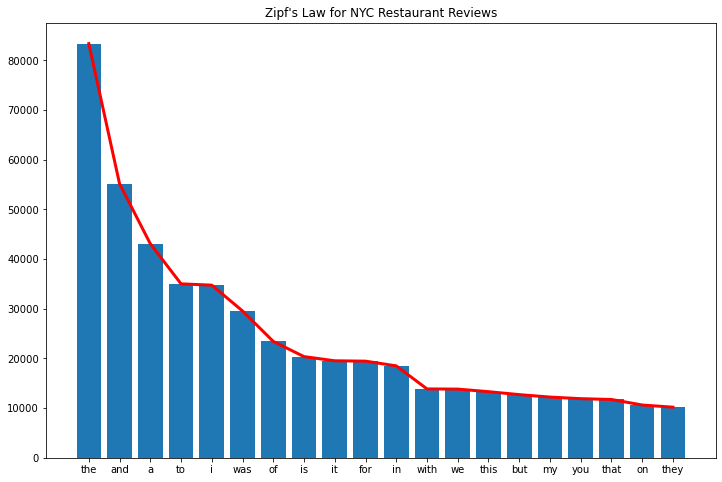

In [34]:
# Visualize 
plt.figure(figsize=(12,8))
plt.bar(zipf_df.index, zipf_df['count'])
plt.plot(zipf_df['count'], color='red', linewidth=3)
plt.title('Zipf\'s Law for NYC Restaurant Reviews')
plt.show()

## Conclusion

Now that we've gotten our data, we need to trim it down into a more usable format. The next step in exploratory analysis, we will use tokenization and stemming to get a better idea of what the actual meaning behind each review is. Once you remove common, or stop words like 'the' 'and' 'to' and all those, you can really get an idea of what each review is saying. We'll handle that part next!

---